## Загрузим нужные библиотеки

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import numpy as np
from sklearn.metrics import f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, PowerTransformer, MinMaxScaler, Normalizer
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
import re
from random import randint
from catboost import CatBoostClassifier, Pool, cv
from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# %matplotlib inline

In [2]:
# pip install XGBoost

In [3]:
df = pd.read_csv("train_dataset_train.csv", parse_dates=['Дата_Рождения'])
df_test = pd.read_csv("test_dataset_test.csv", parse_dates=['Дата_Рождения'])
df_submission = pd.read_csv("sample_submission.csv")

## Рассмотрим датасет по ближе

In [4]:
df.head(3)

,ID,Код_группы,Год_Поступления,Пол,Основания,Изучаемый_Язык,Дата_Рождения,Уч_Заведение,Где_Находится_УЗ,Год_Окончания_УЗ,...,Общежитие,Наличие_Матери,Наличие_Отца,Страна_Родители,Опекунство,Село,Иностранец,КодФакультета,СрБаллАттестата,Статус
0,72716,16019,2015,Жен,ОО,Английский язык,1998-02-08,"МБОУ ""СОШ №59""","Алтайский край, Барнаул г",2014.0,...,0.0,0,0.0,Россия,0.0,0.0,0.0,41.0,4.294,3
1,63306,14895,2010,Муж,ЦН,NaN,1992-04-18,NaN,NaN,NaN,...,0.0,1,1.0,Россия,0.0,0.0,0.0,28.0,67.000,4
2,82469,20103,2017,Жен,ДН,Английский язык,1999-03-21,МБОУ Алтайская СОШ №5,"Алтайский край, Алтайский р-н, Алтайское с",2017.0,...,0.0,1,1.0,Россия,0.0,0.0,0.0,41.0,4.133,4


In [5]:
df.shape

(13584, 24)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13584 entries, 0 to 13583
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ID                13584 non-null  int64         
 1   Код_группы        13584 non-null  int64         
 2   Год_Поступления   13584 non-null  int64         
 3   Пол               13577 non-null  object        
 4   Основания         13584 non-null  object        
 5   Изучаемый_Язык    12758 non-null  object        
 6   Дата_Рождения     13584 non-null  datetime64[ns]
 7   Уч_Заведение      12351 non-null  object        
 8   Где_Находится_УЗ  12203 non-null  object        
 9   Год_Окончания_УЗ  12284 non-null  float64       
 10  Пособие           12576 non-null  float64       
 11  Страна_ПП         13237 non-null  object        
 12  Регион_ПП         12966 non-null  object        
 13  Город_ПП          13141 non-null  object        
 14  Общежитие         1349

In [7]:
df.describe()

,ID,Код_группы,Год_Поступления,Год_Окончания_УЗ,Пособие,Общежитие,Наличие_Матери,Наличие_Отца,Опекунство,Село,Иностранец,КодФакультета,СрБаллАттестата,Статус
count,13584.000000,13584.000000,13584.000000,12284.000000,12576.0,13498.000000,13584.000000,13584.000000,13584.000000,13498.000000,13274.000000,13584.000000,13584.000000,13584.000000
mean,70096.056905,18302.499926,2014.992123,2013.876018,0.0,0.219884,0.511484,0.509570,0.000442,0.229441,0.070589,32.500368,73.223274,3.426458
std,12705.894531,2540.417956,2.595339,4.247111,0.0,0.414184,0.499886,0.499927,0.021013,0.420489,0.256147,8.458150,258.045027,1.071765
min,44632.000000,11550.000000,2001.000000,1973.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000,0.000000,-1.000000
25%,63496.750000,16901.000000,2013.000000,2013.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,26.000000,47.000000,3.000000
50%,71401.500000,18534.500000,2015.000000,2015.000000,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,28.000000,61.000000,4.000000
75%,78404.250000,20599.000000,2016.000000,2016.000000,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,40.000000,75.000000,4.000000
max,264403.000000,22824.000000,2212.000000,2020.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,53.000000,5000.000000,4.000000


In [8]:
df['Страна_ПП'].unique()

array(['Россия', nan, 'Казахстан', 'Кыргызстан', 'Китай', 'Таджикистан',
       'Казахстан Респ', 'Киргизия', 'Казахстан респ', 'РОССИЯ',
       'Армения', 'Туркменистан', 'Нигерия', 'Таджикистан Респ',
       'Росссия', 'Узбекистан', 'Кыргызия', 'Франция',
       'Кыргызская Республика', 'Монголия', 'Казахстан ВКО',
       'Республика Казахстан', 'Республика Таджикистан', 'Украина'],
      dtype=object)

Заменим все пропуски в данных

In [9]:
# df = df.fillna(0)

Пострим на распределение данных

Text(0.5, 1.0, 'Распределение предсказываемой величены')

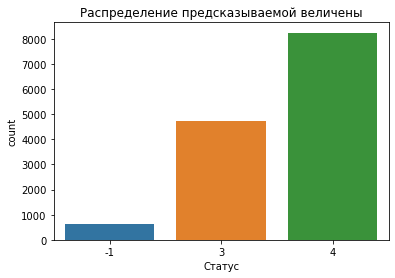

In [10]:
sns.countplot(x = "Статус" , data  = df).set_title('Распределение предсказываемой величены')

Text(0.5, 1.0, 'Распределение года поступления')

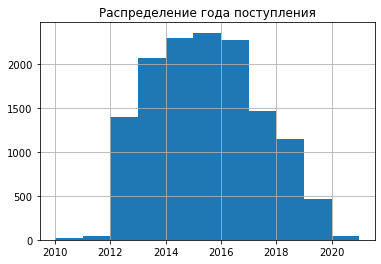

In [11]:
df["Год_Поступления"].hist(bins = 11, range = [2010, 2021]).set_title('Распределение года поступления')

Взглянем на несколько величин сразу

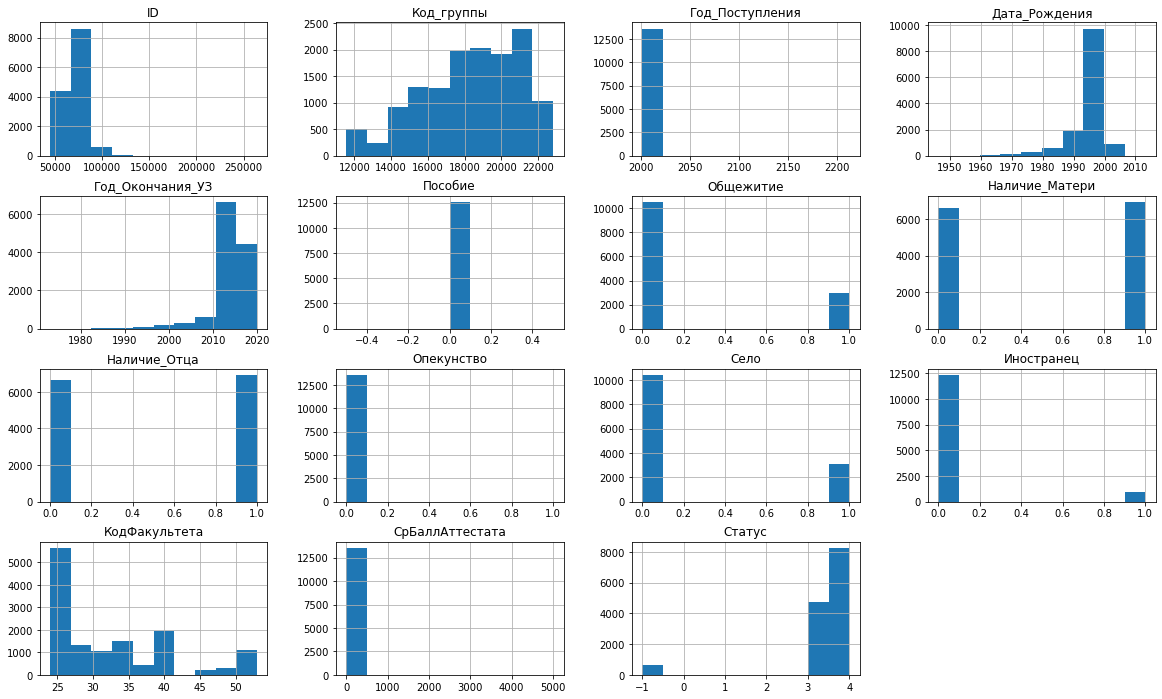

In [12]:
_ = df[df.columns].hist(figsize=(20,12))

Обратим внимание на часть столбцов с постоянными значениями

In [13]:
df["Пособие"].value_counts()

0.0    12576
Name: Пособие, dtype: int64

In [14]:
df["Опекунство"].value_counts()

0.0    13578
1.0        6
Name: Опекунство, dtype: int64

In [15]:
df.columns.values

array(['ID', 'Код_группы', 'Год_Поступления', 'Пол', 'Основания',
       'Изучаемый_Язык', 'Дата_Рождения', 'Уч_Заведение',
       'Где_Находится_УЗ', 'Год_Окончания_УЗ', 'Пособие', 'Страна_ПП',
       'Регион_ПП', 'Город_ПП', 'Общежитие', 'Наличие_Матери',
       'Наличие_Отца', 'Страна_Родители', 'Опекунство', 'Село',
       'Иностранец', 'КодФакультета', 'СрБаллАттестата', 'Статус'],
      dtype=object)

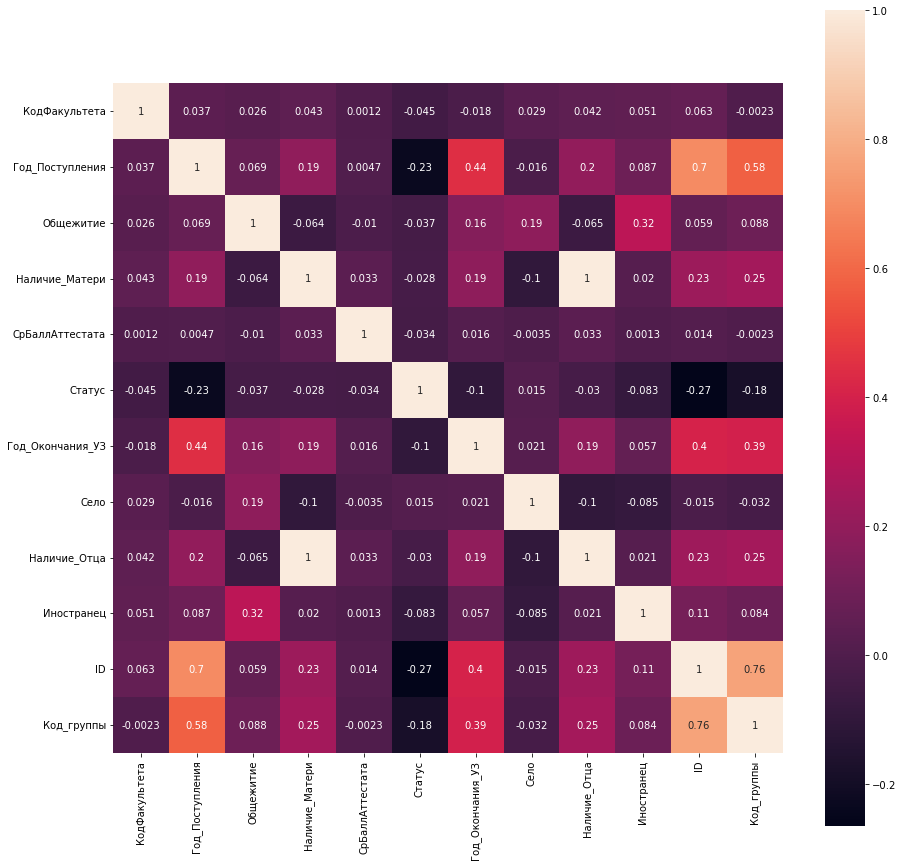

In [16]:
plt.rcParams['figure.figsize']=(15,15)


df_corr = list(set(df.columns.values) - set(['Опекунство','Пособие']))
g = sns.heatmap(df[df_corr].corr(), square = True, annot=True)

In [17]:
# sns.pairplot(df, hue='Статус')

**Вывод**

1. 
2. 
3. Пропуски:
    - `Пол`
    - `Изучаемый_Язык`
    - `Уч_Заведение`
    - `Где_Находится_УЗ`
    - `Год_Окончания_УЗ`
    - `Пособие`
    - `Страна_ПП`
    - `Регион_ПП`
    - `Город_ПП`
    - `Общежитие`
    - `Страна_Родители`
    - `Село`
    - `Иностранец`
4. Не достоверные данные:
    - `Год_Поступления` - 2212
    - `СрБаллАттестата` - надо бработать в зависимости от страны, ЕГЭ и неправильных данных

## Подготовка данных



### Обработка пропусков

Пропуски обработаем следующим образом:
- `Пол` - "Неизвестно"
- `Изучаемый_Язык` - "Английский язык"
- `Уч_Заведение`
- `Где_Находится_УЗ`
- `Год_Окончания_УЗ` - заполним годом поступления;
- `Пособие` - "0"
- `Страна_ПП`
- `Регион_ПП`
- `Город_ПП`
- `Общежитие` - "0" или в иногородним "1"??
- `Страна_Родители`
- `Село`
- `Иностранец`

In [18]:
# Пропущенный год окончания УЗ = году поступления
df.loc[df['Год_Окончания_УЗ'].isna(), 'Год_Окончания_УЗ'] = df.loc[df['Год_Окончания_УЗ'].isna(), 'Год_Поступления']
df_test.loc[df['Год_Окончания_УЗ'].isna(), 'Год_Окончания_УЗ'] = df_test.loc[df['Год_Окончания_УЗ'].isna(), 'Год_Поступления']

In [19]:
# Список колонок типа float
mass_float = df.dtypes[df.dtypes == "float64"].index.values

df[mass_float] = df[mass_float].astype('int64', errors='ignore')

In [20]:
# Список колонок типа object
mass_object = df.dtypes[df.dtypes == "object"].index.values
# Список колонок числовых типов
mass_numeryc = df.dtypes[(df.dtypes == "int64")|(df.dtypes == "float64")].index.values
mass_numeryc

array(['ID', 'Код_группы', 'Год_Поступления', 'Год_Окончания_УЗ',
       'Пособие', 'Общежитие', 'Наличие_Матери', 'Наличие_Отца',
       'Опекунство', 'Село', 'Иностранец', 'КодФакультета',
       'СрБаллАттестата', 'Статус'], dtype=object)

In [21]:
df[mass_object] = df[mass_object].fillna('неизвестно')
df[mass_numeryc] = df[mass_numeryc].fillna(0)

df_test[mass_object] = df_test[mass_object].fillna('неизвестно')
df_test[np.delete(mass_numeryc, -1)] = df_test[np.delete(mass_numeryc, -1)].fillna(0)

### Текстовые признаки

In [22]:
df['Пол'] = df['Пол'].apply(str.lower)
df_test['Пол'] = df_test['Пол'].apply(str.lower)
# df['Пол'].value_counts()

In [23]:
def lang_search(text):
    text = str.lower(text)
    if re.search(r'англ', text):
        return 'английский'
    elif re.search(r'немецкий', text):
        return 'немецкий'
    elif re.search(r'французский', text):
        return 'французский'
    elif  re.search(r'русский', text):
        return 'русский'
    # return 'неизвстно'
    return 'английский'

df['Изучаемый_Язык'] = df['Изучаемый_Язык'].apply(lang_search)
df_test['Изучаемый_Язык'] = df_test['Изучаемый_Язык'].apply(lang_search)

In [24]:
# df['Уч_Заведение'].value_counts().head(30)

In [25]:
def learn_search(text):
    text = str.lower(text)
    if re.search(r'универ', text) or re.search(r'гу', text):
        return 'универ'
    elif re.search(r'сош', text) or re.search(r'школа', text) or re.search(r'сш', text):
        return 'сош'
    elif re.search(r'гимназ', text):
        # return 'гимназия'
        return 'сош'
    elif  re.search(r'колледж', text):
        # return 'колледж'
        return 'сош'
    elif  re.search(r'лицей', text):
        # return 'лицей'
        return 'сош'
    elif  re.search(r'академ', text):
        # return 'академия'
        return 'универ'
    elif  re.search(r'инсти', text):
        # return 'институт'
        return 'универ'
    elif  re.search(r'техник', text):
        # return 'техникум'
        return 'сош'
    elif  re.search(r'кадет', text):
        # return 'кадет'
        return 'сош'
    elif  re.search(r'профессио', text):
        return 'пту'
    return 'другое'
    # return 'сош'

df['Уч_Заведение'] = df['Уч_Заведение'].apply(learn_search)
df_test['Уч_Заведение'] = df_test['Уч_Заведение'].apply(learn_search)

In [26]:
# df['Где_Находится_УЗ'].value_counts().head(30)

In [27]:
def situation_search(text):
    text = str.lower(text)
    if re.search(r'алтай', text) or re.search(r'барнаул', text):
        return 'алтай'
    
    return 'другой'

df['Где_Находится_УЗ'] = df['Где_Находится_УЗ'].apply(situation_search)
df_test['Где_Находится_УЗ'] = df_test['Где_Находится_УЗ'].apply(situation_search)


In [28]:
def country_search(text):
    text = str.lower(text)
    if re.search(r'рос', text):
        return 'россия'
    elif re.search(r'казах', text):
        return 'казахстан'
    elif re.search(r'таджик', text):
        return 'таджикистан'
    elif  re.search(r'кыргыз', text):
        return 'кыргызстан'
    elif re.search(r'киргиз', text):
        return 'кыргызстан'
    
    # return 'неизвестно'
    return 'россия'

df['Страна_ПП'] = df['Страна_ПП'].apply(country_search)
df_test['Страна_ПП'] = df_test['Страна_ПП'].apply(country_search)


In [29]:
def region_search(text):
    text = str.lower(text)
    if re.search(r'алтай', text):
        return 'алтай'
    
    return 'другой'

df['Регион_ПП'] = df['Регион_ПП'].apply(region_search)
df_test['Регион_ПП'] = df_test['Регион_ПП'].apply(region_search)

In [30]:
def city_search(text):
    text = str.lower(text)
    line = text.split(' ')
    max_i = 0
    max_item = 'неизвестно'
    for item in line:
        if len(item) > max_i:
            max_item = item
            max_i = len(item)
    
    return max_item

df['Город_ПП'] = df['Город_ПП'].apply(city_search)
df_test['Город_ПП'] = df_test['Город_ПП'].apply(city_search)

In [31]:
df['Страна_Родители'] = df['Страна_Родители'].apply(country_search)
df_test['Страна_Родители'] = df_test['Страна_Родители'].apply(country_search)

### Недостоверные данные, выбросы

In [32]:
df.loc[104, 'Год_Поступления'] = 2012

In [33]:
df['Страна_ПП'].unique()

array(['россия', 'казахстан', 'кыргызстан', 'таджикистан'], dtype=object)

In [34]:
df['СрБаллАттестата'].describe()

count    13584.000000
mean        73.223274
std        258.045027
min          0.000000
25%         47.000000
50%         61.000000
75%         75.000000
max       5000.000000
Name: СрБаллАттестата, dtype: float64

<AxesSubplot:>

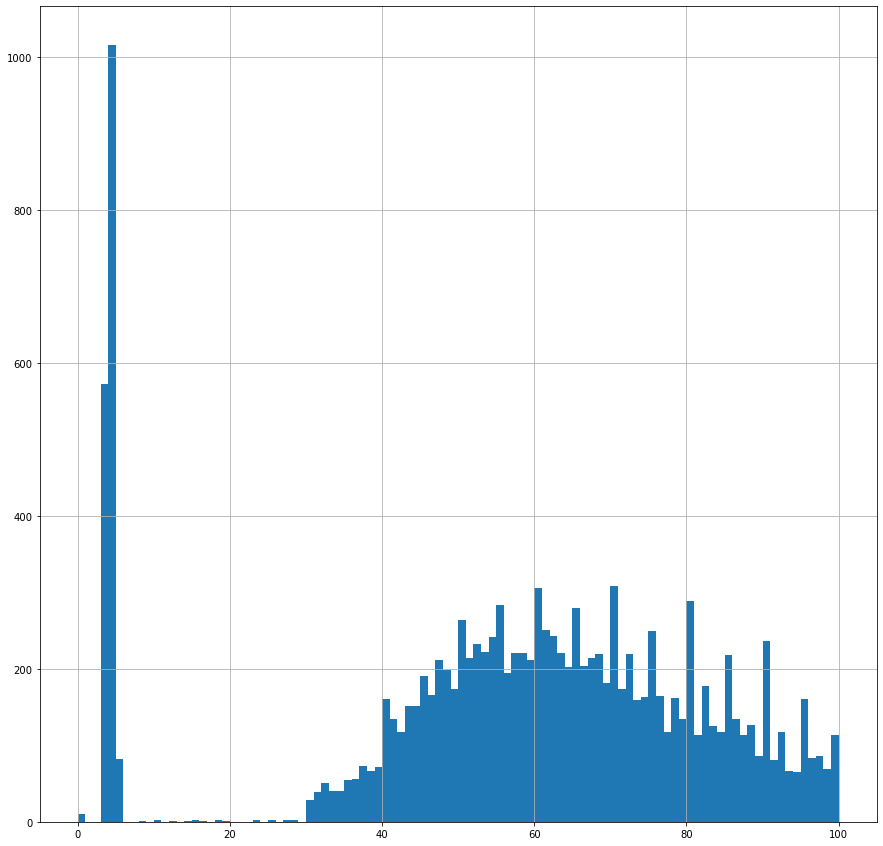

In [35]:
df[(df['СрБаллАттестата'] > -1) & (df['СрБаллАттестата'] <200) & (df['Страна_ПП'] == 'россия')]['СрБаллАттестата'].hist(bins=100)
# df[(df['СрБаллАттестата'] > 5) & (df['СрБаллАттестата'] <30)]

In [36]:
def preproc_attestat(line):
    ball = line['СрБаллАттестата']
    # if line['Страна_ПП'] == 'россия':
    if ball > 1000:
        return ball / 1000
    elif ball > 500:
        return ball / 200
    elif ball > 100:
        return ball / 100
    elif ball > 29: 
        return min((ball - 30) / 20 + 3, 5)
    # elif ball > 10:
    #     return ball / 5
    elif ball > 5:
        # return ball / 2
        return 4
    elif ball == 0:
        return 4
        
    # elif line['Страна_ПП'] == 'кыргызстан':
    #     if ball > 1000:
    #         return ball / 1000
    #     elif ball > 5:
    #         return ball / 20
    return ball

# df.loc[df['Страна_ПП'] == 'кыргызстан', 'СрБаллАттестата'] = df.loc[df['Страна_ПП'] == 'кыргызстан', :].apply(preproc_attestat, axis=1)
df['СрБаллАттестата'] = df.apply(preproc_attestat, axis=1)
df_test['СрБаллАттестата'] = df_test.apply(preproc_attestat, axis=1)


In [37]:
# df[df['Страна_ПП'] == 'кыргызстан']['СрБаллАттестата'].describe()

In [38]:
# df['СрБаллАттестата'].describe()

### Подготовка признаков

In [39]:
# Список колонок типа object
df.dtypes[df.dtypes == "object"].index.values

array(['Пол', 'Основания', 'Изучаемый_Язык', 'Уч_Заведение',
       'Где_Находится_УЗ', 'Страна_ПП', 'Регион_ПП', 'Город_ПП',
       'Страна_Родители'], dtype=object)

In [40]:
df[['Где_Находится_УЗ', 'Страна_ПП', ]].head(5)

,Где_Находится_УЗ,Страна_ПП
0,алтай,россия
1,другой,россия
2,алтай,россия
3,алтай,россия
4,алтай,россия


Поместим все столбцы object в массив, для их дальнейшего удаления

In [41]:
category_columns = [
                    'Пол', 
                    'Основания', 
                    'Изучаемый_Язык',
                    # 'Дата_Рождения',
                    'Уч_Заведение', 
                    'Где_Находится_УЗ', 
                    'Страна_ПП', 
                    # 'Регион_ПП',
                    # 'Город_ПП', 
                    'Страна_Родители'
                   ]
# mass_object = df.dtypes[df.dtypes == "object"].index.values

In [42]:
numeric_columns = ['ID',
                   'Код_группы',
                   'Год_Поступления',
                   'Год_Окончания_УЗ',
                   # 'Пособие',
                   'Общежитие', 
                   # 'Наличие_Матери', 
                   # 'Наличие_Отца',
                   # 'Опекунство', 
                   'Село', 
                   'Иностранец', 
                   'КодФакультета',
                   'СрБаллАттестата',
                  ]

In [43]:
def create_features(data):
    """ Принимаем датасет
        Возвращаем датасет с добавлением признаков
    """
    data['Год_рождения'] = data['Дата_Рождения'].dt.year
    data['Возраст_поступления'] = data['Год_Поступления'] - data['Год_рождения']
    # df['Возраст_поступления_20'] = df['Возраст_поступления'].apply(lambda x: 1 if x > 18 else 0)
    data['лет_между'] = data['Год_Поступления'] - data['Год_Окончания_УЗ']
    data['Месяц_рождения'] = data['Дата_Рождения'].dt.month
    data['Месяц_рождения'] = data['Месяц_рождения'].apply(lambda x: 1 if (x > 4) and (x < 10) else 0)
    data['родители_иностранцы'] = data['Страна_Родители'].apply(lambda x: 0 if x == 'россия' else 1)
    # data['СрБаллАттестата'] = data['СрБаллАттестата'].apply(lambda x: x**2)
    data[['Код_группы_1','Код_группы_2']] = [_ for _ in data['Код_группы'].apply(lambda kod: [int(str(kod)[:3]), int(str(kod)[3:])])]
    return data

In [44]:
# Количество студентов в группе
# df_train_test = pd.concat([df, df_test])
# students_on_group = df_train_test.groupby('Код_группы')['ID'].count()

# Количество студентов в группе
students_on_group = df.groupby('Код_группы')['ID'].count()
students_on_group.name = 'Студентов_в_группе'
# Добавляем в датасеты
df = df.merge(students_on_group, on='Код_группы', how='left')
df_test = df_test.merge(students_on_group, on='Код_группы', how='left')
df_test = df_test.fillna(0)

In [45]:
# Количество студентов на факультете
students_on_facult = df.groupby('КодФакультета')['ID'].count()
students_on_facult.name = 'Студентов_на_факультете'

df = df.merge(students_on_facult, on='КодФакультета')
df_test = df_test.merge(students_on_facult, on='КодФакультета', how='left')
df_test = df_test.fillna(0)

In [46]:
df = create_features(df)
df_test = create_features(df_test)
df.head()

,ID,Код_группы,Год_Поступления,Пол,Основания,Изучаемый_Язык,Дата_Рождения,Уч_Заведение,Где_Находится_УЗ,Год_Окончания_УЗ,...,Статус,Студентов_в_группе,Студентов_на_факультете,Год_рождения,Возраст_поступления,лет_между,Месяц_рождения,родители_иностранцы,Код_группы_1,Код_группы_2
0,72716,16019,2015,жен,ОО,английский,1998-02-08,сош,алтай,2014.0,...,3,2,1485,1998,17,1.0,0,0,160,19
1,82469,20103,2017,жен,ДН,английский,1999-03-21,сош,алтай,2017.0,...,4,10,1485,1999,18,0.0,0,0,201,3
2,72669,18733,2015,муж,СН,английский,1997-11-13,сош,алтай,2015.0,...,3,2,1485,1997,18,0.0,0,0,187,33
3,81843,20091,2017,жен,ОО,английский,2001-04-23,сош,алтай,2017.0,...,3,1,1485,2001,16,0.0,0,0,200,91
4,72581,17440,2015,жен,ОО,немецкий,1997-08-05,сош,алтай,2015.0,...,4,7,1485,1997,18,0.0,1,0,174,40


In [83]:
features_columns = [
                    'Год_рождения',
                    # 'Возраст_поступления',
#     !!!!!!!!!!!
                    # 'лет_между',
                    # 'Месяц_рождения',
                    # 'Возраст_поступления_20',
                    'Студентов_в_группе',
                    # 'Студентов_на_факультете',
                    # 'родители_иностранцы',
                    # 'Код_группы_1',
                    'Код_группы_2',
]

In [48]:
# Преобразуем тип даннных категориальных признаков из object в category для правильной работы в LGBM
df[mass_object] = df[mass_object].astype('category')
df_test[mass_object] = df_test[mass_object].astype('category')

## Выделим выборки

In [84]:
X = df[category_columns + numeric_columns + features_columns]
# X = X.drop("Статус", axis = 1)
# X = X.drop(num_object_drop, axis = 1)

y = df[["Статус"]]

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [86]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = 99999)

In [87]:
preprocessor_OHE = ColumnTransformer(transformers=[#('num', Normalizer(), numeric_columns+features_columns),
                                                   ('cat', OneHotEncoder(drop='first', 
                                                                         handle_unknown='ignore'), category_columns)
                                                  ],
                                     remainder='passthrough'
                                    )

In [88]:
# X_train[category_columns] = encoder.fit_transform(X_train[category_columns])
X_original = X.copy()
X[category_columns] = encoder.fit_transform(X[category_columns])
# X = oh_encoder.fit_transform(X)

X.head()

C:\Users\USER\AppData\Local\Temp\ipykernel_6200\1535534293.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[category_columns] = encoder.fit_transform(X[category_columns])


,Пол,Основания,Изучаемый_Язык,Уч_Заведение,Где_Находится_УЗ,Страна_ПП,Страна_Родители,ID,Код_группы,Год_Поступления,Год_Окончания_УЗ,Общежитие,Село,Иностранец,КодФакультета,СрБаллАттестата,Год_рождения,Студентов_в_группе,Код_группы_2
0,0.0,2.0,0.0,2.0,0.0,2.0,2.0,72716,16019,2015,2014.0,0.0,0.0,0.0,41.0,4.294,1998,2,19
1,0.0,1.0,0.0,2.0,0.0,2.0,2.0,82469,20103,2017,2017.0,0.0,0.0,0.0,41.0,4.133,1999,10,3
2,1.0,3.0,0.0,2.0,0.0,2.0,2.0,72669,18733,2015,2015.0,0.0,0.0,0.0,41.0,3.692,1997,2,33
3,0.0,2.0,0.0,2.0,0.0,2.0,2.0,81843,20091,2017,2017.0,0.0,0.0,0.0,41.0,4.470,2001,1,91
4,0.0,2.0,1.0,2.0,0.0,2.0,2.0,72581,17440,2015,2015.0,1.0,0.0,0.0,41.0,4.600,1997,7,40


In [89]:
X_original.head()

,Пол,Основания,Изучаемый_Язык,Уч_Заведение,Где_Находится_УЗ,Страна_ПП,Страна_Родители,ID,Код_группы,Год_Поступления,Год_Окончания_УЗ,Общежитие,Село,Иностранец,КодФакультета,СрБаллАттестата,Год_рождения,Студентов_в_группе,Код_группы_2
0,жен,ОО,английский,сош,алтай,россия,россия,72716,16019,2015,2014.0,0.0,0.0,0.0,41.0,4.294,1998,2,19
1,жен,ДН,английский,сош,алтай,россия,россия,82469,20103,2017,2017.0,0.0,0.0,0.0,41.0,4.133,1999,10,3
2,муж,СН,английский,сош,алтай,россия,россия,72669,18733,2015,2015.0,0.0,0.0,0.0,41.0,3.692,1997,2,33
3,жен,ОО,английский,сош,алтай,россия,россия,81843,20091,2017,2017.0,0.0,0.0,0.0,41.0,4.470,2001,1,91
4,жен,ОО,немецкий,сош,алтай,россия,россия,72581,17440,2015,2015.0,1.0,0.0,0.0,41.0,4.600,1997,7,40


In [90]:
X.shape

(13584, 19)

In [91]:
X_ohe = preprocessor_OHE.fit_transform(X_original)
X_ohe.shape 

(13584, 31)

In [92]:
# X_test[category_columns] = encoder.transform(X_test[category_columns])


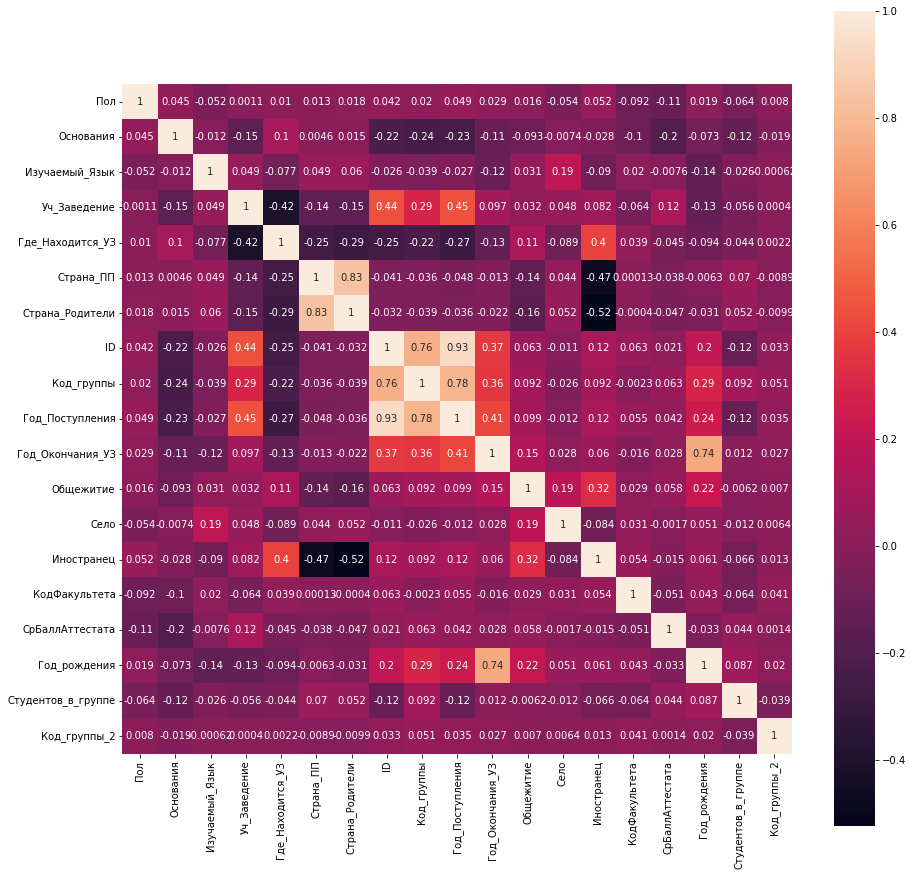

In [93]:
plt.rcParams['figure.figsize']=(15,15)

# X_corr = list(set(X.columns.values) - set(['Опекунство','Пособие']))
g = sns.heatmap(X[category_columns + numeric_columns + features_columns].corr(), square = True, annot=True)

In [59]:
# sns.pairplot(df[category_columns + numeric_columns + features_columns + ['Статус']], hue='Статус')

## Обучение модели

### LogisticRegression

In [60]:
# lr = LogisticRegression(C=10)
# np.mean(cross_val_score(lr, X, y, scoring='f1_macro'))

### RandomForestClassifier

In [61]:
rf_clf = RandomForestClassifier(n_estimators=850, 
                                max_depth=30, 
                                class_weight='balanced_subsample',
                                random_state=12345)
np.mean(cross_val_score(rf_clf, X, y, scoring='f1_macro'))

C:\Users\USER\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\USER\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\USER\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\USER\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was pa

0.7004605611186107

In [62]:
%%time
# CatBoost с автоподбором параметров
parametrs = { 'n_estimators': range(100,1001, 50),
              # 'learning_rate': [0.01, 0.02, 0.05, 0.08, 0.1, 0.2, 0.5, 0.8, 1],
              'max_depth' : range(1,50)
}

rf_clf = RandomForestClassifier(random_state=12345)
randCV_rf = RandomizedSearchCV(rf_clf, 
                               parametrs, 
                               scoring='f1_macro', 
                               cv=5, 
                               n_iter=10,
                               n_jobs=-1,
                               random_state=12345)
randCV_rf.fit(X, y)
print('Параметры модели:', randCV_rf.best_params_)
print('Лучший f1 модели:', randCV_rf.best_score_)

KeyboardInterrupt: 

### CatBoostClassifier

In [63]:
%%time
cb_clf = CatBoostClassifier(learning_rate=0.3,
                            l2_leaf_reg=18,
                            depth=7,
                            silent=True,
                            iterations=400,
                            auto_class_weights='SqrtBalanced',
                            random_state=12345)
cb_clf.fit(X_train, y_train, cat_features=category_columns, silent=True)
pred = cb_clf.predict(X_test)
f1_score(y_test, pred, average='macro', zero_division = 0) 

CPU times: total: 2min 53s
Wall time: 40.2 s


0.7772833533933557

In [101]:
%%time
# CatBoost с автоподбором параметров
parametrs = { 'l2_leaf_reg': range(1,30),
              'learning_rate': [0.01, 0.02, 0.05, 0.08, 0.1, 0.2, 0.5, 0.8, 1],
              'depth' : range(1,10)
}

cb_clf = CatBoostClassifier(iterations=500,
                            auto_class_weights='SqrtBalanced',
                            silent=True)
randCV_cat = RandomizedSearchCV(cb_clf, 
                                parametrs, 
                                scoring='f1_macro', 
                                cv=5, 
                                n_iter=10,
                                n_jobs=-1,
                                random_state=5555)
randCV_cat.fit(X_ohe, y)
print('Параметры модели:', randCV_cat.best_params_)
print('Лучший f1 модели:', randCV_cat.best_score_)

Параметры модели: {'learning_rate': 0.02, 'l2_leaf_reg': 25, 'depth': 6}
Лучший f1 модели: 0.735650108205725
CPU times: total: 36.2 s
Wall time: 2min 18s


In [120]:
# num = X_ohe[:, 0:26].sum(axis=0)
# X_ohe[:, 0:26] *= num

In [118]:
%%time
cb_clf = CatBoostClassifier(learning_rate=0.26,
                            l2_leaf_reg=18,
                            depth=7,
                            # loss_function='MultiClassOneVsAll',
                            silent=True,
                            iterations=500,
                            auto_class_weights='SqrtBalanced',
                            random_state=12345
                           )
# cb_clf = CatBoostClassifier(#iterations=500,
#                             # loss_function='MultiClassOneVsAll',
#                             auto_class_weights='SqrtBalanced',
#                             random_state=12345
#                            )
# cb_clf.fit(X, y,  cat_features=category_columns, silent=True)

np.mean(cross_val_score(cb_clf, 
                        # X_ohe, 
                        X,
                        y, 
                        n_jobs=-1, 
                        scoring='f1_macro'))

CPU times: total: 78.1 ms
Wall time: 15.8 s


0.7222088024042583

In [95]:
cb_clf.randomized_search(param_distributions=parametrs,
                         X=X,
                         y=y,
                         cv=5,
                         verbose=False,
                        )


bestTest = 0.3633686483
bestIteration = 361


bestTest = 0.4037376736
bestIteration = 141


Iteration with suspicious time 422 sec ignored in overall statistics.
Training on fold [0/5]

bestTest = 0.4171412587
bestIteration = 394

Training on fold [1/5]

bestTest = 0.3823596107
bestIteration = 398

Training on fold [2/5]

bestTest = 0.4040880668
bestIteration = 307

Training on fold [3/5]

bestTest = 0.3881713476
bestIteration = 396

Training on fold [4/5]

bestTest = 0.3597800294
bestIteration = 388



{'params': {'depth': 4, 'iterations': 400},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
       

#### CatBoostClassifier с самостоятельной обработкой категориальных признаков

In [1421]:
# Тренировочный пул
train_pool = Pool(data=X_original,
                  label=y,
                  # feature_names=['text'],
                  cat_features=category_columns
                 )
# Тестовый пул
# valid_pool = Pool(data=features_valid.values,
#                    label=target_valid.values,
#                    feature_names = ['text'],
#                    text_features=['text']
#                   )

In [1422]:
params = {'learning_rate': 0.3,
          'l2_leaf_reg':18,
          'depth':7,
          'silent': True,
          'iterations': 400,
          'random_state': 12345,
          # 'loss_function': "MultiClass",
          'auto_class_weights':'SqrtBalanced',
          # 'verbose': False
         }

scores = cv(train_pool,
            params,
            fold_count=5, 
            plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4156170859
bestIteration = 183

Training on fold [1/5]

bestTest = 0.3830529943
bestIteration = 225

Training on fold [2/5]

bestTest = 0.4018012607
bestIteration = 180

Training on fold [3/5]

bestTest = 0.3928514541
bestIteration = 289

Training on fold [4/5]

bestTest = 0.3684095914
bestIteration = 247



In [656]:
%%time
cat_model = CatBoostClassifier(silent=True,
                            iterations=400,
                            random_state=12345
                           )
# CatBoostRegressor с автоподбором параметров
param_grid = {'l2_leaf_reg': range(1,20),
              'learning_rate': [0.1, 0.2, 0.23, 0.25, 0.27, 0.3, 0.35],
              'depth' : range(1,15)
              }

cat_model.randomized_search(param_grid,
            X=train_pool,
            cv=5,
            partition_random_seed=12345,
            verbose=False,
            plot=True
            )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.3922621113
bestIteration = 399


bestTest = 0.2939754377
bestIteration = 394


bestTest = 0.2960034357
bestIteration = 395


bestTest = 0.2858299047
bestIteration = 396


bestTest = 0.2837325721
bestIteration = 399


bestTest = 0.2985480979
bestIteration = 89


bestTest = 0.2867697465
bestIteration = 399


bestTest = 0.2938248494
bestIteration = 279


bestTest = 0.2947066946
bestIteration = 225


bestTest = 0.3121251898
bestIteration = 60

Training on fold [0/5]

bestTest = 0.2902465082
bestIteration = 399

Training on fold [1/5]

bestTest = 0.2976696448
bestIteration = 387

Training on fold [2/5]

bestTest = 0.2970003682
bestIteration = 354

Training on fold [3/5]

bestTest = 0.2750606021
bestIteration = 399

Training on fold [4/5]

bestTest = 0.2890402528
bestIteration = 399

CPU times: total: 1h 41min 37s
Wall time: 19min 55s


{'params': {'depth': 7, 'l2_leaf_reg': 18, 'learning_rate': 0.3},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
    

### LGBMClassifier

In [583]:
%%time
lgbm_clf = LGBMClassifier(n_estimators=280, 
                          learning_rate=0.01,
                          # max_depth=15,
                          # boosting_type='goss',
                          random_state=12345,
                          # class_weight='balanced',
                           )

np.mean(cross_val_score(lgbm_clf, 
                        # X,
                        X_original, 
                        # X_ohe,
                        y, 
                        n_jobs=-1, 
                        scoring='f1_macro'))

CPU times: total: 78.1 ms
Wall time: 6.7 s


0.7310638828215593

In [1598]:
%%time
# LGBMRegressor с автоподбором параметров
parametrs = { 'n_estimators': range(200, 401, 10),
              'learning_rate': [0.001, 0.003, 0.005, 0.008, 0.01, 0.02, 0.05, 0.07, 0.1, 0.2, 0.5],
              'max_depth': range(20,70),
              'num_leaves': range(30,80),
            }

lgbm_clf = LGBMClassifier(random_state=12345)
randCV_lgbm = RandomizedSearchCV(lgbm_clf, 
                                 parametrs, 
                                 scoring='f1_macro',
                                 cv=5,
                                 n_iter=20,
                                 n_jobs=-1,
                                 random_state=5555
                                 )
randCV_lgbm.fit(X_original, y)
print('Параметры модели:', randCV_lgbm.best_params_)
print('Лучший F1 модели:', randCV_lgbm.best_score_)

C:\Users\USER\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\USER\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Параметры модели: {'num_leaves': 69, 'n_estimators': 360, 'max_depth': 61, 'learning_rate': 0.008}
Лучший F1 модели: 0.7257788715392761
CPU times: total: 16.6 s
Wall time: 52.6 s


Параметры модели: {'n_estimators': 200, 'learning_rate': 0.02}
Лучший F1 модели: 0.7202722350746995
CPU times: total: 2min 30s3

### XGBoostClassifier

In [152]:
def y_for_xgb(data):

    yy = []
    for i in data['Статус']:
        i -= 2
        yy.append(max(0,i))
    return yy

def y_convert(data):
    
    result = []
    
    for i in data:
        i += 2
        if i == 2:
            i = -1
        result.append(i)
    return result
    
yy = y_for_xgb(y)


In [321]:
%%time
xgb_clf = XGBClassifier(n_estimators=480, 
                        learning_rate=0.01,
                        # max_depth=15,
                        n_jobs=-1,
                        random_state=12345,
                        # num_parallel_tree=2,
                        # class_weight='balanced',
                        # enable_categorical=True
                       )

np.mean(cross_val_score(xgb_clf, 
                        X_ohe,
                        # X_original, 
                        yy, 
                        n_jobs=-1, 
                        scoring='f1_macro'))

CPU times: total: 46.9 ms
Wall time: 39.5 s


0.716322324589205

In [1726]:
%%time
# XGBClassifier с автоподбором параметров
parametrs = { 'n_estimators': range(200, 501, 10),
              'learning_rate': [0.001, 0.003, 0.005, 0.008, 0.01, 0.02, 0.05, 0.07, 0.1, 0.2, 0.5],
              'max_depth': range(5,70),
              # 'num_leaves': range(30,80),
            }

xgb_clf = XGBClassifier(random_state=12345)
randCV_xgb = RandomizedSearchCV(xgb_clf, 
                                parametrs, 
                                scoring='f1_macro',
                                cv=5,
                                n_iter=10,
                                n_jobs=-1,
                                random_state=5555
                               )
randCV_xgb.fit(X, yy)
print('Параметры модели:', randCV_xgb.best_params_)
print('Лучший F1 модели:', randCV_xgb.best_score_)

Параметры модели: {'n_estimators': 290, 'max_depth': 19, 'learning_rate': 0.5}
Лучший F1 модели: 0.7145709372052294
CPU times: total: 59.1 s
Wall time: 7min 59s


In [1717]:
print('Параметры модели:', randCV_xgb.best_params_)
print('Лучший F1 модели:', randCV_xgb.best_score_)

Параметры модели: {'n_estimators': 480, 'learning_rate': 0.01}
Лучший F1 модели: 0.7184252528012409


# Cоздание файла с ответом

### CatBoost

In [103]:
# обучение лучшей модели на полном наборе тренировочных данных
# 0.771373 Cat learning_rate=0.2, l2_leaf_reg=8, depth=6, iterations=200
# 0.771373 Cat learning_rate=0.25, l2_leaf_reg=8, depth=7, iterations=200
# cv=0.775508 test=0.773353 Cat learning_rate=0.27, l2_leaf_reg=8, depth=6, iterations=200 + СрБалл - РодителиИностр
# cv=0.779850 test=0.771849 Cat learning_rate=0.25, l2_leaf_reg=8, depth=6, iterations=500 
# cv=0.723156 test=0.788169 Cat learning_rate=0.3, l2_leaf_reg=18, depth=7, iterations=500 +вторая часть кода группы
# cv=0.721987 test=0.793186 Cat learning_rate=0.3, l2_leaf_reg=18, depth=7, iterations=500 +вторая часть кода группы + 'SqrtBalanced'
# cv=0.720919 test=0.790814 Cat learning_rate=0.3, l2_leaf_reg=18, depth=9, iterations=500 +вторая часть кода группы + 'SqrtBalanced' + OHE
# cv=0.726318 test=0.789270 Cat learning_rate=0.3, l2_leaf_reg=18, depth=9, iterations=500 +вторая часть кода группы + 'SqrtBalanced' + OHE без drop=first
# cv=0.723825 test=0.783230 Cat learning_rate=0.3, l2_leaf_reg=18, depth=7, iterations=500 +вторая часть кода группы + 'SqrtBalanced'  Страна_ПП - неизвестно
# cv=0.727494 test=0.783108 Cat learning_rate=0.3, l2_leaf_reg=18, depth=7, iterations=500 +вторая часть кода группы + 'SqrtBalanced' + Регион_ПП 
# cv=0.725188 test=0.787535 Cat learning_rate=0.3, l2_leaf_reg=18, depth=6, iterations=500 +вторая часть кода группы + 'SqrtBalanced' + Регион_ПП 
# cv=0.723743 test=0.787884 Cat learning_rate=0.28, l2_leaf_reg=18, depth=6, iterations=500 +вторая часть кода группы + 'SqrtBalanced'
# cv=0.720030 test=0.784122 Cat learning_rate=0.3, l2_leaf_reg=18, depth=5, iterations=500 +вторая часть кода группы + 'SqrtBalanced'
# cv=0.721771 test=0.782869 Cat learning_rate=0.3, l2_leaf_reg=19, depth=7, iterations=500 +вторая часть кода группы + 'SqrtBalanced'
# cv=0.716126 test=0.786763 Cat default
# cv=0.724255 test=0.789235 Cat default 'SqrtBalanced'
# cv=0.738673 test=0.779110 Cat default 'SqrtBalanced' loss_function='MultiClassOneVsAll'
# cv=0.737411 test=0.780760 Cat default 'SqrtBalanced' loss_function='MultiClassOneVsAll' -Kod2
# cv=0.726277 test=0.786004 Cat learning_rate=0.3, l2_leaf_reg=18, depth=7, iterations=500 +вторая часть кода группы + 'SqrtBalanced'  
# cv=0.718244 test=0.795950 Cat learning_rate=0.3, l2_leaf_reg=18, depth=7, iterations=500 +вторая часть кода группы + 'SqrtBalanced' Англ вместо неизв 
# cv=0.725889 test=0.788098 Cat learning_rate=0.3, l2_leaf_reg=18, depth=7, iterations=500 +вторая часть кода группы + 'SqrtBalanced' Англ вместо неизв loss_function
# cv=0.742321 test=0.759980 Cat learning_rate=0.02, l2_leaf_reg=25, depth=6, iterations=500 +вторая часть кода группы + 'SqrtBalanced' Англ вместо неизв 
# cv=0.732615 test=0.784316 Cat learning_rate=0.1, l2_leaf_reg=11, depth=9, iterations=500 +вторая часть кода группы + 'SqrtBalanced' Англ вместо неизв 
# cv=0.722508 test=0.791319 Cat default 'SqrtBalanced'
# cv=0.724562 test=0.786790 Cat default 'SqrtBalanced' iterations=500
# cv=0.720524 test=0.785991 Cat learning_rate=0.3, l2_leaf_reg=18, depth=7, iterations=500 +вторая часть кода группы + 'SqrtBalanced'  -лет между
# cv=0.718276 test=0.789750 Cat learning_rate=0.3, l2_leaf_reg=18, depth=7, iterations=500 +вторая часть кода группы + 'SqrtBalanced'  -лет между - возраст пост
# cv=0.742321 test=0.761011 Cat learning_rate=0.02, l2_leaf_reg=25, depth=6, iterations=500 +вторая часть кода группы + 'SqrtBalanced' -лет между - возраст пост
# cv=0.721754 test=0.798660 Cat learning_rate=0.28, l2_leaf_reg=18, depth=7, iterations=500 +вторая часть кода группы + 'SqrtBalanced' -лет между - возраст пост


In [110]:
best_clf = CatBoostClassifier(learning_rate=0.28,
                              l2_leaf_reg=18,
                              depth=7,
                              # loss_function='MultiClassOneVsAll',
                              silent=True,
                              iterations=500,
                              auto_class_weights='SqrtBalanced',
                              random_state=12345
                             )
# best_clf = CatBoostClassifier(#loss_function='MultiClassOneVsAll',
#                               iterations=500,
#                               auto_class_weights='Balanced', 
#                               random_state=12345
#                              )
best_clf.fit(X, y, silent=True)

### CatBoost без обработки категориальных признаков

In [1423]:
# cv=0.721987 test=0.789454 Cat learning_rate=0.3, l2_leaf_reg=18, depth=7, iterations=500 +первая часть кода группы + 'SqrtBalanced'

best_clf = CatBoostClassifier(learning_rate=0.3,
                            l2_leaf_reg=18,
                            depth=7,
                            silent=True,
                            iterations=500,
                            auto_class_weights='SqrtBalanced',
                            random_state=12345)
best_clf.fit(X_original, y, cat_features=category_columns, silent=True)

### LightGBM

In [316]:
%%time
# cv=0.728492 test=0.750148 Cat n_estimators=250, learning_rate=0.01
# cv=0.729173 test=0.756496 Cat n_estimators=280, learning_rate=0.01 original

best_clf = LGBMClassifier(n_estimators=280, 
                          learning_rate=0.01,
                          random_state=12345,
                          # class_weight='balanced',
                           )
best_clf.fit(X_original, y)

C:\Users\USER\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\USER\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: total: 6.91 s
Wall time: 1.05 s


LGBMClassifier(learning_rate=0.01, n_estimators=280, random_state=12345)

### XGBClassifier

In [1735]:
# cv=0.718425 test=0.759623 Cat n_estimators=480, learning_rate=0.01

%%time
best_clf = XGBClassifier(n_estimators=480, 
                        learning_rate=0.01,
                        n_jobs=-1,
                        random_state=12345,
                       )
best_clf.fit(X, yy)

CPU times: total: 59.1 s
Wall time: 8.09 s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=480,
              n_jobs=-1, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=12345, reg_alpha=0, ...)

### Прогнозирование на тестовых данных

In [111]:
X_submint = df_test[category_columns + numeric_columns + features_columns]
X_submint[category_columns] = encoder.transform(X_submint[category_columns])
# X_submint = preprocessor_OHE.transform(X_submint)

C:\Users\USER\AppData\Local\Temp\ipykernel_6200\1959766718.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_submint[category_columns] = encoder.transform(X_submint[category_columns])


In [112]:
df_test_pred = best_clf.predict(X_submint)

In [113]:
df_submission["Статус"] = df_test_pred
# df_submission["Статус"] = y_convert(df_test_pred)

df_submission.head(4)

,ID,Статус
0,64996,4
1,71837,4
2,86587,-1
3,73673,-1


In [114]:
df_submission.to_csv("submission_53_cat__sqrb_-между-возр_028 18 7.csv", index=False)

## Оценка важности факторов

In [678]:
# pred = clf.predict(X)

# f1_score(y_test, pred, average='macro', zero_division = 0) 

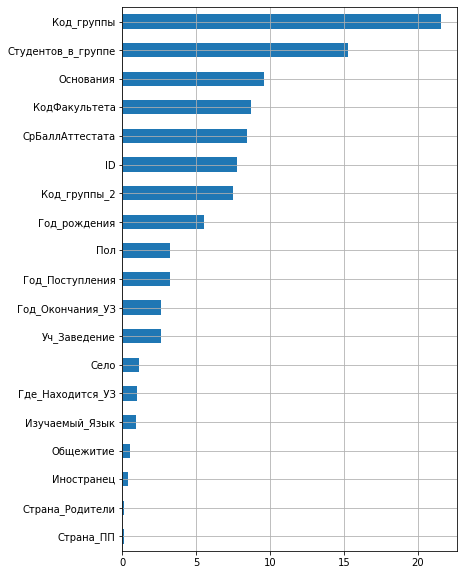

In [115]:
# Выделим наиболее важные признаки
efectiv_score = pd.DataFrame(data={'score': best_clf.feature_importances_}, 
                            index=X.columns).sort_values(by='score')
# Выведем их на экран
efectiv_score.plot(kind='barh', grid=True, figsize=(6,10), legend=False);
